In [1]:
# @title Step 0: Install Required Libraries
!pip install -q -U \
    langchain \
    langchain-core \
    langchain-community \
    langchain-text-splitters \
    langchain-google-genai \
    langchain-huggingface \
    sentence-transformers \
    faiss-cpu \
    tiktoken


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.1/719.1 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [2]:
# @title Step 1: Mount Drive & Verify Input Files
from google.colab import drive
import os

drive.mount('/content/drive')

OLD_POLICY_PATH = "/content/drive/MyDrive/PolicyProject/instagram/policy_v1.txt"
NEW_POLICY_PATH = "/content/drive/MyDrive/PolicyProject/instagram/policy_v2.txt"

if os.path.exists(OLD_POLICY_PATH):
    print("Old policy file located.")
else:
    print("Old policy file not found.")

if os.path.exists(NEW_POLICY_PATH):
    print("New policy file located.")
else:
    print("New policy file not found.")


Mounted at /content/drive
Old policy file located.
New policy file located.


In [3]:
# @title Step 2: Remove Common Sentences
import re

def load_file(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def remove_common_sentences(old_text, new_text):
    def split_sentences(text):
        return re.split(r'(?<=[.!?])\s+', text)

    old_sents = split_sentences(old_text)
    new_sents = split_sentences(new_text)

    old_set = set(s.strip() for s in old_sents)
    new_set = set(s.strip() for s in new_sents)

    common = old_set.intersection(new_set)

    old_unique = [s for s in old_sents if s.strip() not in common]
    new_unique = [s for s in new_sents if s.strip() not in common]

    return " ".join(old_unique), " ".join(new_unique)

old_raw = load_file(OLD_POLICY_PATH)
new_raw = load_file(NEW_POLICY_PATH)

old_text, new_text = remove_common_sentences(old_raw, new_raw)

print("Original lengths:", len(old_raw), len(new_raw))
print("Optimized lengths:", len(old_text), len(new_text))
print(f"Reduced content by approximately: {100 - (len(new_text)/len(new_raw)*100):.0f}%")


Original lengths: 124025 132597
Optimized lengths: 55781 64347
Reduced content by approximately: 51%


In [4]:
# @title Step 3: Chunk Policies into Semantic Units
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150
)

old_chunks = splitter.create_documents([old_text])
new_chunks = splitter.create_documents([new_text])

print(f"Old chunks: {len(old_chunks)}")
print(f"New chunks: {len(new_chunks)}")


Old chunks: 105
New chunks: 112


In [5]:
# @title Step 4: Build Vector Store for Semantic Retrieval
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L12-v2"
)
# pretrained model text to embeddings

vector_store = FAISS.from_documents(old_chunks, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k": 1})

print("Vector store initialized")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vector store initialized


In [6]:
# @title Step 5: Cosine Similarity Scoring
import numpy as np

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def compute_similarity(text1, text2, embedding_model):
    v1 = embedding_model.embed_query(text1)
    v2 = embedding_model.embed_query(text2)
    sim = cosine_similarity(v1, v2)
    return float(sim)


In [7]:
# @title Step 6: Semantic Change Index
def semantic_change_index(similarity: float) -> str:
    if similarity >= 0.95:
        return "NO_SEMANTIC_CHANGE"
    elif similarity >= 0.75:
        return "CLARIFICATION_NEEDED"
    else:
        return "LLM_CHECK"

def confidence_score(semantic_index: str):
    scores = {
        "NO_SEMANTIC_CHANGE": 0.95,
        "CLARIFICATION_NEEDED": 0.75
    }
    return scores.get(semantic_index, 0.6)


In [8]:
# @title Step 7: Semantic Alignment
def align_documents(new_docs, retriever, embeddings):
    aligned = []

    for doc in new_docs:
        match = retriever.invoke(doc.page_content)
        if not match:
            continue

        old_doc = match[0]
        sim = compute_similarity(doc.page_content, old_doc.page_content, embeddings)

        aligned.append({
            "new_content": doc.page_content,
            "old_content": old_doc.page_content,
            "similarity": round(sim, 3),
            "semantic_index": semantic_change_index(sim)
        })

    return aligned

aligned_pairs = align_documents(new_chunks, retriever, embeddings)
print(f"Aligned pairs: {len(aligned_pairs)}")


Aligned pairs: 112


In [9]:
# @title Step 8: LLM Setup
import os
import time
from typing import Literal
from pydantic import BaseModel, Field

from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

class ChangeAnalysis(BaseModel):
    change_detected: bool
    classification: Literal[
        "BREAKING",
        "NON_BREAKING",
        "CLARIFICATION",
        "NEW_FEATURE",
        "NO_CHANGE"
    ]
    confidence: float
    reasoning: str

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

structured_llm = llm.with_structured_output(ChangeAnalysis)

prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a Senior Regulatory Compliance Analyst AI. "
        "You will only be asked to analyze policy sections where a semantic change "
        "has already been detected by an upstream machine learning system. "
        "Do NOT classify changes as NO_CHANGE or CLARIFICATION."
    ),
    (
        "human",
        """
Two versions of a policy section are shown below.
A semantic change is already confirmed.

OLD VERSION:
{old_text}

NEW VERSION:
{new_text}

Your task:

1. Analyze how the change affects user or developer behavior.
2. Classify the change into exactly ONE of the following categories:

- NON_BREAKING:
  The change modifies or adds constraints but does NOT require users to change
  existing behavior to remain compliant.

- BREAKING:
  The change introduces new restrictions, removes permissions, or requires
  users to change behavior to remain compliant.

- NEW_FEATURE:
  The change introduces an entirely new rule, requirement, or capability that
  did not exist previously.

3. Provide a confidence score between 0.0 and 1.0.
   - High confidence (≥0.8): impact is clear and unambiguous.
   - Medium confidence (0.6–0.79): some interpretation required.
   - Low confidence (<0.6): borderline or ambiguous impact.

Respond strictly using the structured output schema provided.
"""
    )
])



In [11]:
# @title Step 9: Token Throttling
class TokenThrottle:
    def __init__(self, tokens_per_minute=180_000):
        self.tokens_per_minute = tokens_per_minute
        self.used = 0
        self.start = time.time()

    def consume(self, tokens):
        now = time.time()
        if now - self.start > 60:
            self.used = 0
            self.start = now

        if self.used + tokens > self.tokens_per_minute:
            time.sleep(60 - (now - self.start))
            self.used = 0
            self.start = time.time()

        self.used += tokens


In [12]:
# @title Step 10: Hybrid Execution
def analyze_impact(aligned_pairs):
    results = []
    for i, pair in enumerate(aligned_pairs):
        try:
            sim = pair["similarity"]
            s_index = pair["semantic_index"]

            print(f"\n--- Pair {i+1} ---")
            print(f"Similarity Score   : {sim}")
            print(f"Semantic Index     : {s_index}")

            # Rule-based decisions

            if s_index == "NO_SEMANTIC_CHANGE":
                classification = "NO_CHANGE"
                reasoning = "High semantic similarity; no meaningful change detected."
                confidence = confidence_score(s_index)

                print("Decision Path      : RULE-BASED")
                print("Classification     : NO_CHANGE")

            elif s_index == "CLARIFICATION_NEEDED":
                classification = "CLARIFICATION"
                reasoning = "Moderate similarity; wording clarified without intent change."
                confidence = confidence_score(s_index)

                print("Decision Path      : RULE-BASED")
                print("Classification     : CLARIFICATION")

            # LLM-based decision
            else:
                print("Decision Path      : LLM-BASED")
                print("LLM Status         : Invoked")

                # LLM Call
                parsed = (prompt | structured_llm).invoke({
                    "old_text": pair["old_content"],
                    "new_text": pair["new_content"]
                })

                classification = parsed.classification
                reasoning = parsed.reasoning   # LLM output
                confidence = parsed.confidence

                print("Classification     :", classification)
                print("LLM Reasoning      :", reasoning)
                print(f"LLM Confidence     : {confidence:.2f}")

            results.append({
                "pair_id": i,
                "classification": classification,
                "semantic_index": s_index,
                "similarity": sim,
                "confidence": round(confidence, 2),
                "reasoning": reasoning
            })

        except Exception as e:
            if "429" in str(e):
                print("\n RATE LIMIT HIT (429)")
                print(f"Execution stopped at pair {i+1}")
                print(f"Pairs processed safely: {len(results)}")
                break
            else:
                print(f"Error at pair {i+1}: {e}")
                continue
    return results

final_report = analyze_impact(aligned_pairs)


--- Pair 1 ---
Similarity Score   : 0.937
Semantic Index     : CLARIFICATION_NEEDED
Decision Path      : RULE-BASED
Classification     : CLARIFICATION

--- Pair 2 ---
Similarity Score   : 0.748
Semantic Index     : LLM_CHECK
Decision Path      : LLM-BASED
LLM Status         : Invoked
Classification     : NEW_FEATURE
LLM Reasoning      : The new policy explicitly adds 'Interactions with AI at Meta and related metadata' as a category of content that is collected. This introduces a new scope of data collection related to user interactions with AI, which was not previously mentioned. This constitutes a new capability for data collection by Meta.
LLM Confidence     : 0.95

--- Pair 3 ---
Similarity Score   : 0.77
Semantic Index     : CLARIFICATION_NEEDED
Decision Path      : RULE-BASED
Classification     : CLARIFICATION

--- Pair 4 ---
Similarity Score   : 0.738
Semantic Index     : LLM_CHECK
Decision Path      : LLM-BASED
LLM Status         : Invoked
Classification     : NEW_FEATURE
LLM R

In [20]:
llm_decisions = df[df['decision_path'] == 'LLM']

with open('llm_reasoning.txt', 'w', encoding='utf-8') as f:
    for index, row in llm_decisions.iterrows():
        output = f"Pair ID: {row['pair_id']}\nClassification: {row['classification']}\nReasoning: {row['reasoning']}\n\n---\n\n"
        print(output)
        f.write(output)

Pair ID: 1
Classification: NEW_FEATURE
Reasoning: The new policy explicitly adds 'Interactions with AI at Meta and related metadata' as a category of content that is collected. This introduces a new scope of data collection related to user interactions with AI, which was not previously mentioned. This constitutes a new capability for data collection by Meta.

---


Pair ID: 3
Classification: NEW_FEATURE
Reasoning: The new version introduces an entirely new section detailing the collection of information about 'friends, followers, groups, accounts, Facebook Pages and other users and communities that you're connected to and interact with on and off Meta Products.' This significantly expands the scope of data collection beyond the previously stated 'contacts' information that users choose to upload or import. This represents a new, explicitly stated data collection capability or feature of the policy.

---


Pair ID: 8
Classification: NEW_FEATURE
Reasoning: The old policy broadly stated t

In [14]:
# @title Step 11: Summary Metrics
from collections import Counter

def summarize(results):
    return {
        "total_pairs": len(results),
        "distribution": dict(Counter(r["classification"] for r in results)),
        "avg_confidence": round(
            sum(r["confidence"] for r in results) / len(results), 2
        )
    }

summary = summarize(final_report)

print("Analysis Summary")
print(f"Total Aligned Pairs: {summary['total_pairs']}")
print("Change Distribution:")
for classification, count in summary['distribution'].items():
    print(f"  - {classification}: {count}")
print(f"Average Confidence Score: {summary['avg_confidence']:.2f}")

Analysis Summary
Total Aligned Pairs: 111
Change Distribution:
  - CLARIFICATION: 57
  - NEW_FEATURE: 8
  - NO_CHANGE: 43
  - BREAKING: 1
  - NON_BREAKING: 2
Average Confidence Score: 0.84


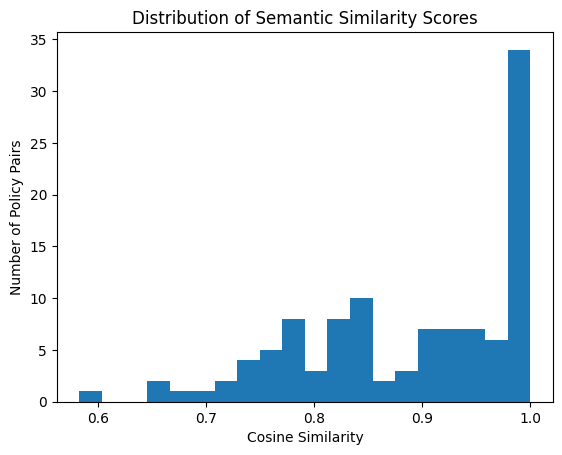

In [15]:
# @title Step 12: Result Analysis
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(final_report)
df.head()


plt.figure()
plt.hist(df["similarity"], bins=20)
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Policy Pairs")
plt.title("Distribution of Semantic Similarity Scores")
plt.show()


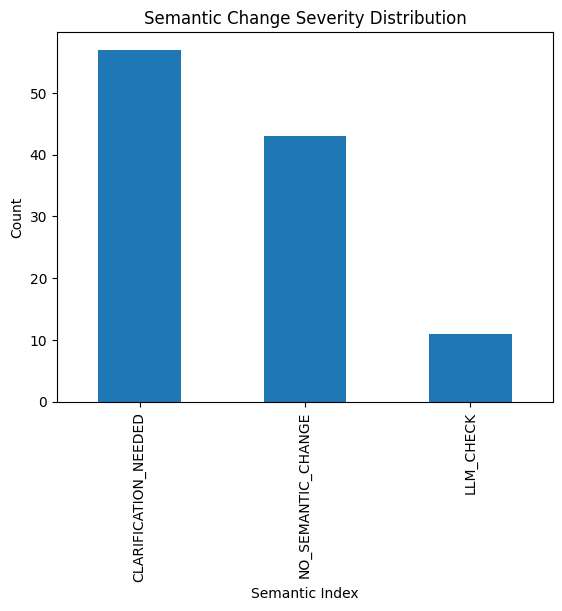

In [16]:
# @title Step 13: Semantic Change Index Distribution
index_counts = df["semantic_index"].value_counts()

plt.figure()
index_counts.plot(kind="bar")
plt.xlabel("Semantic Index")
plt.ylabel("Count")
plt.title("Semantic Change Severity Distribution")
plt.show()

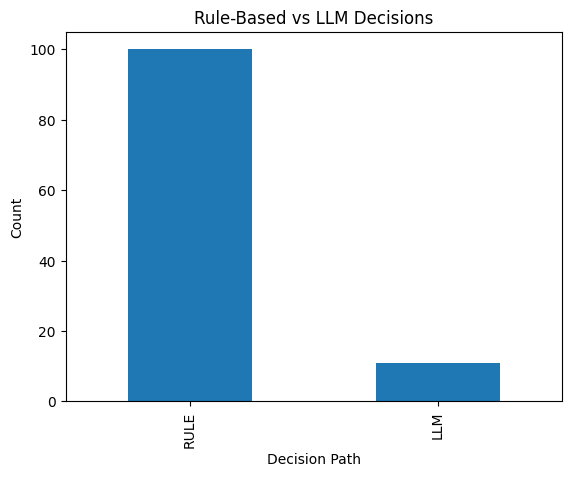

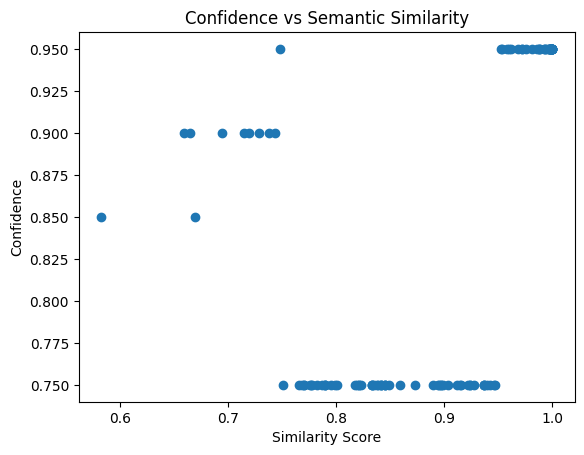

In [17]:
# @title Step 14: Rule-Based vs LLM Decision Split
df["decision_path"] = df["semantic_index"].apply(
    lambda x: "LLM" if x == "LLM_CHECK" else "RULE"
)

path_counts = df["decision_path"].value_counts()

plt.figure()
path_counts.plot(kind="bar")
plt.xlabel("Decision Path")
plt.ylabel("Count")
plt.title("Rule-Based vs LLM Decisions")
plt.show()

plt.figure()
plt.scatter(df["similarity"], df["confidence"])
plt.xlabel("Similarity Score")
plt.ylabel("Confidence")
plt.title("Confidence vs Semantic Similarity")
plt.show()

In [18]:
# @title Step 15: Final Quantitative Summary
finalSummary = {
    "Total Pairs Processed": len(df),
    "LLM Usage (%)": float(round(
        (df["decision_path"] == "LLM").mean() * 100, 2
    )),
    "Average Similarity": float(round(df["similarity"].mean(), 3)),
    "Average Confidence": float(round(df["confidence"].mean(), 3))
}
finalSummary

{'Total Pairs Processed': 111,
 'LLM Usage (%)': 9.91,
 'Average Similarity': 0.89,
 'Average Confidence': 0.842}